In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('CustomerSegmentation.csv')

In [4]:
df.head()

Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
print(df.isnull().sum())

Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

In [9]:
print(df[['Age','Quantity','Price per Unit','Total Amount']].describe())

              Age     Quantity  Price per Unit  Total Amount
count  1000.00000  1000.000000     1000.000000   1000.000000
mean     41.39200     2.514000      179.890000    456.000000
std      13.68143     1.132734      189.681356    559.997632
min      18.00000     1.000000       25.000000     25.000000
25%      29.00000     1.000000       30.000000     60.000000
50%      42.00000     3.000000       50.000000    135.000000
75%      53.00000     4.000000      300.000000    900.000000
max      64.00000     4.000000      500.000000   2000.000000


In [10]:
print(df['Gender'].value_counts())
print(df['Product Category'].value_counts())

Gender
0    510
1    490
Name: count, dtype: int64
Product Category
Clothing       351
Electronics    342
Beauty         307
Name: count, dtype: int64


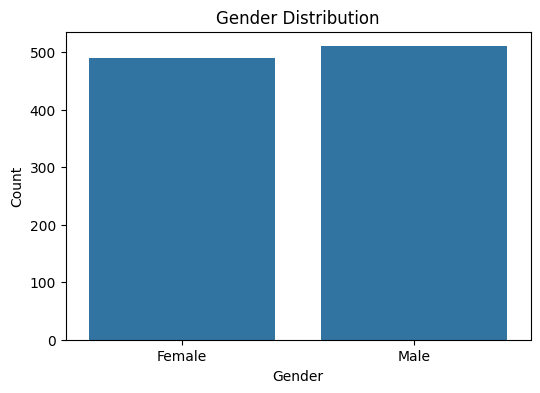

In [11]:
df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})

plt.figure(figsize=(6,4))
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()



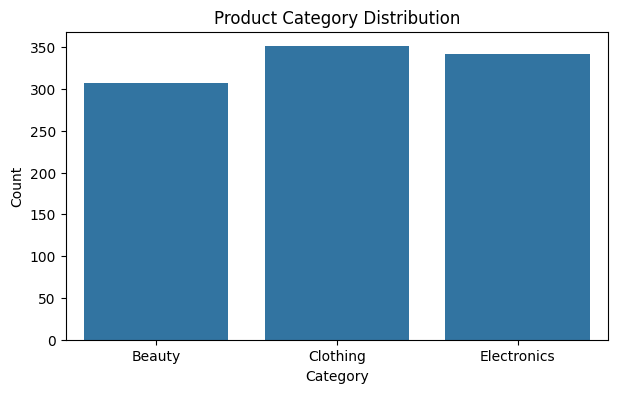

In [12]:
plt.figure(figsize=(7,4))
sns.countplot(x='Product Category', data=df)
plt.title("Product Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


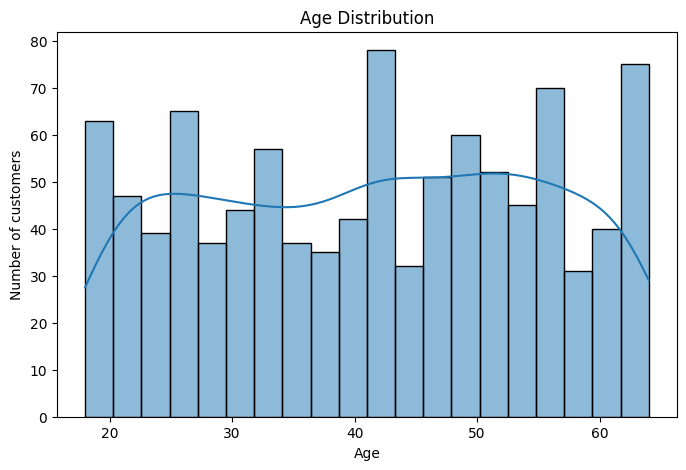

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of customers')
plt.show()


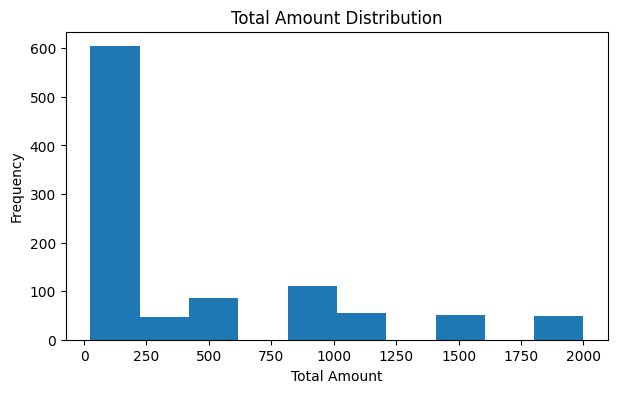

In [14]:
plt.figure(figsize=(7,4))
plt.hist(df['Total Amount'], bins=10)
plt.title("Total Amount Distribution")
plt.xlabel("Total Amount")
plt.ylabel("Frequency")
plt.show()


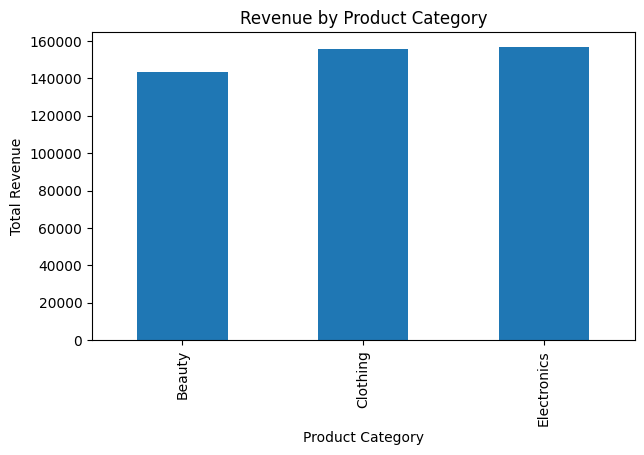

In [15]:
plt.figure(figsize=(7,4))
df.groupby('Product Category')['Total Amount'].sum().plot(kind='bar')
plt.title("Revenue by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.show()


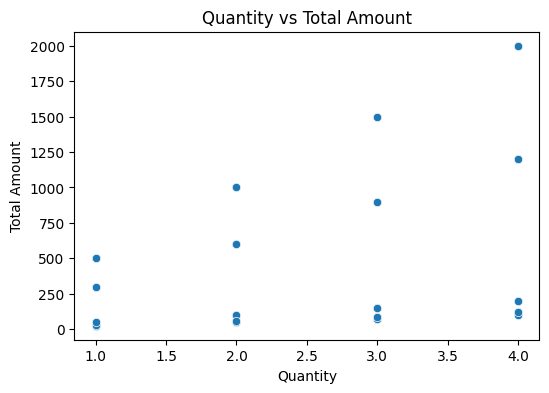

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Quantity', y='Total Amount', data=df)
plt.title("Quantity vs Total Amount")
plt.xlabel("Quantity")
plt.ylabel("Total Amount")
plt.show()


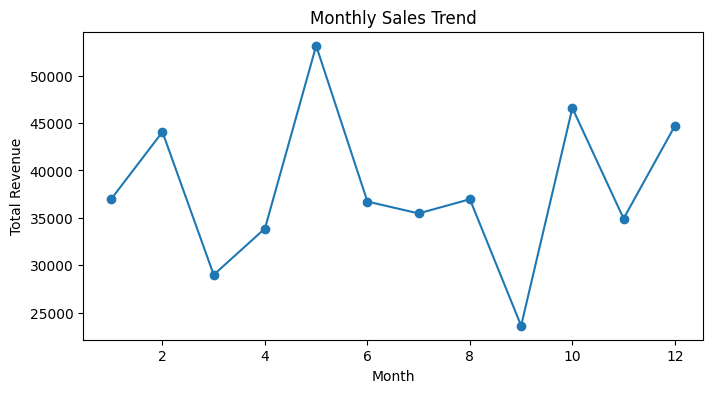

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

plt.figure(figsize=(8,4))
df.groupby('Month')['Total Amount'].sum().plot(marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show()


In [18]:
# customer level aggregation (RFM)
customer_df = df.groupby('Customer ID').agg({
    'Total Amount':'sum',        # Monetary
    'Transaction ID':'count',    # Frequency
    'Date':'max',                # Recency calculation
    'Age':'mean',
    'Gender':'first'
}).reset_index()

In [19]:
# Recency: Days since last purchase
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)
customer_df['Recency'] = (snapshot_date - customer_df['Date']).dt.days  # here we willget number of days before they purchase

In [20]:
customer_df.rename(columns={'Transaction ID':'Frequency','Total Amount':'Monetary'}, inplace=True)
customer_df.drop('Date', axis=1, inplace=True)    # recency already calculated so there no need of date column
customer_df.head()

Customer ID  Monetary  Frequency   Age  Gender  Recency
0     CUST001       150          1  34.0  Female       39
1     CUST002      1000          1  26.0    Male      309
2     CUST003        30          1  50.0  Female      354
3     CUST004       500          1  37.0  Female      226
4     CUST005       100          1  30.0  Female      241

In [21]:
# import datetime
# snapshot_date = df['Date'].max() + pd.Timedelta(days=1)
# customer_df['Recency'] = (snapshot_date - customer_df['Date']).dt.days
# customer_df.rename(columns={'Transaction ID':'Frequency','Total Amount':'Monetary'}, inplace=True)


In [22]:
# Feature Scaling
# recency - days since last purchase
#frequency - number of purchases
#monetary - total spend


In [25]:
scaler = StandardScaler()
features = ['Recency','Frequency','Monetary','Age','Gender']
customer_df['Gender'] = customer_df['Gender'].map({'Male':0, 'Female':1})
X_scaled = scaler.fit_transform(customer_df[features])

In [30]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
customer_df['PC1'] = X_pca[:, 0]
customer_df['PC2'] = X_pca[:, 1]


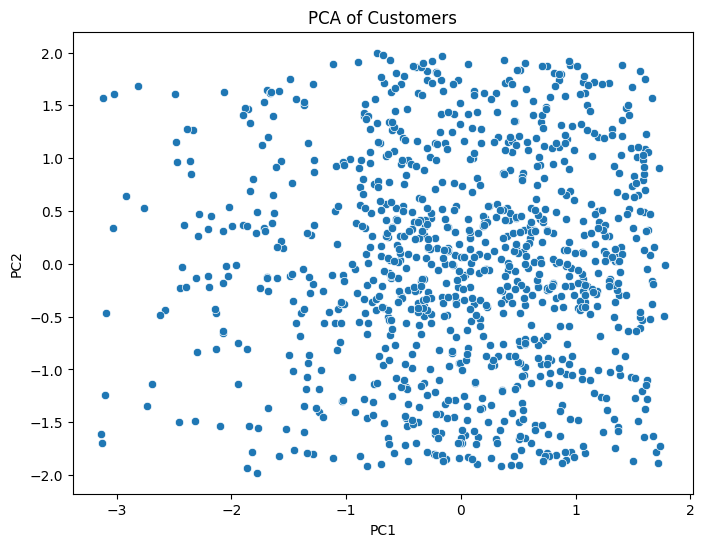

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2',data=customer_df)
plt.title('PCA of Customers')
plt.show()



# KMeans clustering

In [19]:
### finding optimal clusters using elbow method

In [32]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

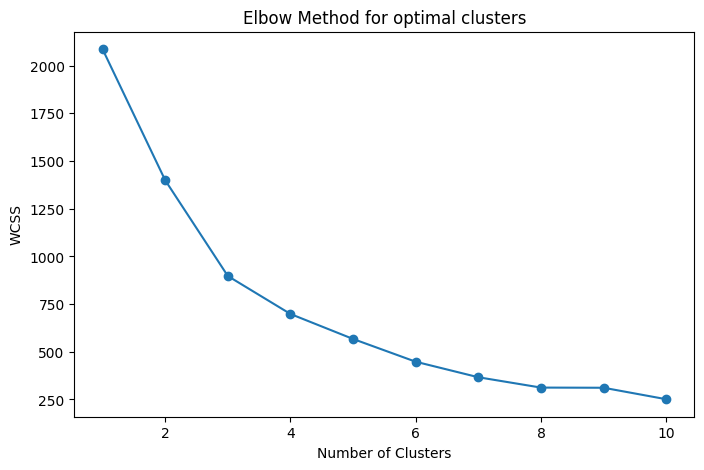

In [33]:
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method for optimal clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [39]:
# fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['KMeans_Cluster'] = kmeans.fit_predict(X_pca)

In [40]:
# Silhouette Score
print('KMeans Silhouette Score:', silhouette_score(X_pca, customer_df['KMeans_Cluster']))


KMeans Silhouette Score: 0.33712947626879963


In [36]:
# fit KMeans
# kmeans = KMeans(n_clusters=4, random_state=42)
# customer_df['KMeans_Cluster'] = kmeans.fit_predict(X_pca)

In [37]:
# print('KMeans Silhouette Score:', silhouette_score(X_pca, customer_df['KMeans_Cluster']))

KMeans Silhouette Score: 0.33875523770936167


In [55]:
customer_df[['Customer ID', 'KMeans_Cluster']].head(10)


Customer ID  KMeans_Cluster
0     CUST001               0
1     CUST002               1
2     CUST003               2
3     CUST004               2
4     CUST005               2
5     CUST006               0
6     CUST007               2
7     CUST008               2
8     CUST009               0
9     CUST010               0

In [56]:
cluster_mapping = customer_df[['Customer ID', 'KMeans_Cluster']].sort_values('KMeans_Cluster')
cluster_mapping


Customer ID  KMeans_Cluster
991     CUST991               0
990     CUST990               0
989     CUST989               0
988     CUST988               0
983     CUST983               0
..          ...             ...
359     CUST359               2
360     CUST360               2
363     CUST363               2
365     CUST365               2
993     CUST993               2

[1000 rows x 2 columns]

In [57]:
cluster_labels = {
    0: 'Budget Customers',
    1: 'Regular Customers',
    2: 'High-Value Customers'
}

customer_df['Customer_Segment'] = customer_df['KMeans_Cluster'].map(cluster_labels)


In [58]:
customer_df[['Customer ID', 'Customer_Segment']].head(10)


Customer ID      Customer_Segment
0     CUST001      Budget Customers
1     CUST002     Regular Customers
2     CUST003  High-Value Customers
3     CUST004  High-Value Customers
4     CUST005  High-Value Customers
5     CUST006      Budget Customers
6     CUST007  High-Value Customers
7     CUST008  High-Value Customers
8     CUST009      Budget Customers
9     CUST010      Budget Customers

In [59]:
customer_df.groupby('Customer_Segment')[['Recency','Frequency','Monetary']].mean()


Recency  Frequency    Monetary
Customer_Segment                                       
Budget Customers      117.273239        1.0  260.577465
High-Value Customers  244.525000        1.0  243.416667
Regular Customers     187.091228        1.0  967.947368

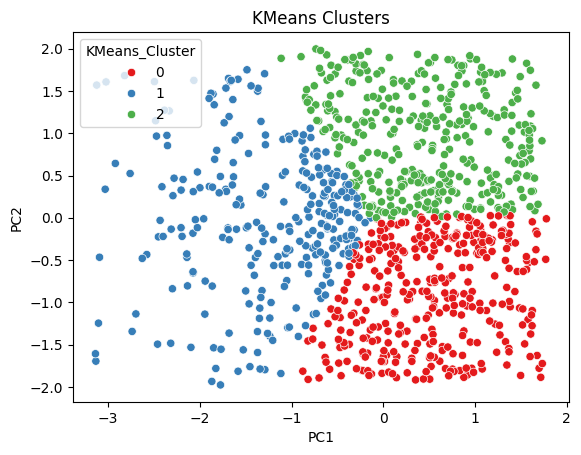

In [41]:
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=customer_df, palette='Set1')
plt.title('KMeans Clusters')
plt.show()

In [30]:
## Hierarchical Clustering

In [42]:
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
customer_df['HC_Cluster'] = hc.fit_predict(X_pca)

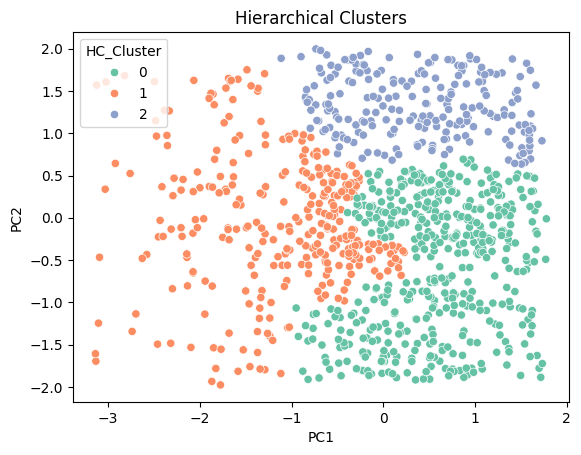

In [43]:
sns.scatterplot(x='PC1', y='PC2', hue='HC_Cluster', data=customer_df, palette='Set2')
plt.title('Hierarchical Clusters')
plt.show()

In [44]:
hc_labels = customer_df['HC_Cluster']
hc_silhouette = silhouette_score(X_pca, hc_labels)
print("Hierarchical Silhouette Score:", hc_silhouette)


Hierarchical Silhouette Score: 0.306169148857774


In [45]:
# DBScan CLustering

In [47]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_pca)



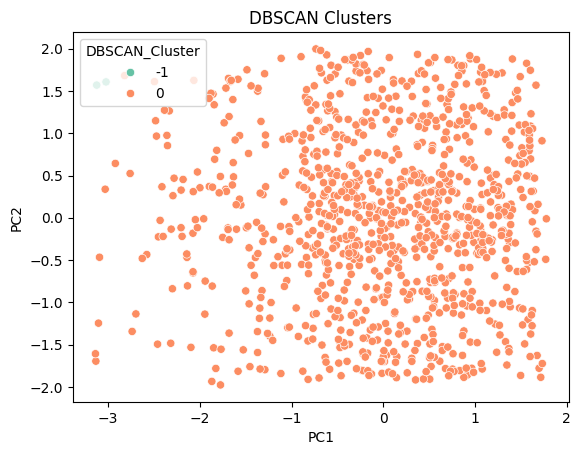

In [48]:
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=customer_df, palette='Set2')
plt.title('DBSCAN Clusters')
plt.show()

In [49]:
dbscan_labels = customer_df['DBSCAN_Cluster']

# Remove noise points (-1)
mask = dbscan_labels != -1

if len(set(dbscan_labels[mask])) > 1:
    dbscan_silhouette = silhouette_score(
        X_pca[mask],
        dbscan_labels[mask]
    )
    print("DBSCAN Silhouette Score:", dbscan_silhouette)
else:
    print("DBSCAN did not form enough clusters for silhouette scoring.")


DBSCAN did not form enough clusters for silhouette scoring.


In [50]:
# Display DBSCAN outliers
outliers = customer_df[customer_df['DBSCAN_Cluster']==-1]
print("DBSCAN Outliers:")
print(outliers)

DBSCAN Outliers:
    Customer ID  Monetary  Frequency   Age  Gender  Recency       PC1  \
257     CUST257      2000          1  19.0       1      317 -3.123097   
577     CUST577      2000          1  21.0       1      323 -3.021673   

          PC2  KMeans_Cluster  HC_Cluster  DBSCAN_Cluster  
257  1.570375               1           1              -1  
577  1.607783               1           1              -1  


In [51]:
cluster_summary = customer_df.groupby('KMeans_Cluster')[['Recency','Frequency','Monetary','Age']].mean()
print(cluster_summary)

                   Recency  Frequency    Monetary        Age
KMeans_Cluster                                              
0               117.273239        1.0  260.577465  46.453521
1               187.091228        1.0  967.947368  30.126316
2               244.525000        1.0  243.416667  45.319444


In [40]:
# Cluster Profiling

In [61]:
# cluster_summary = customer_df.groupby('KMeans_Cluster')[['Recency','Frequency','Monetary','Age','Gender']].mean()
# cluster_counts = customer_df['KMeans_Cluster'].value_counts()
# cluster_summary['Count'] = cluster_counts.values
# # print("Cluster Summary:")
# print(cluster_summary)

In [52]:
comparison = pd.DataFrame({
    'Algorithm': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_score(X_pca, customer_df['KMeans_Cluster']),
        hc_silhouette,
        dbscan_silhouette if 'dbscan_silhouette' in locals() else np.nan
    ]
})

print(comparison)


      Algorithm  Silhouette Score
0        KMeans          0.337129
1  Hierarchical          0.306169
2        DBSCAN               NaN


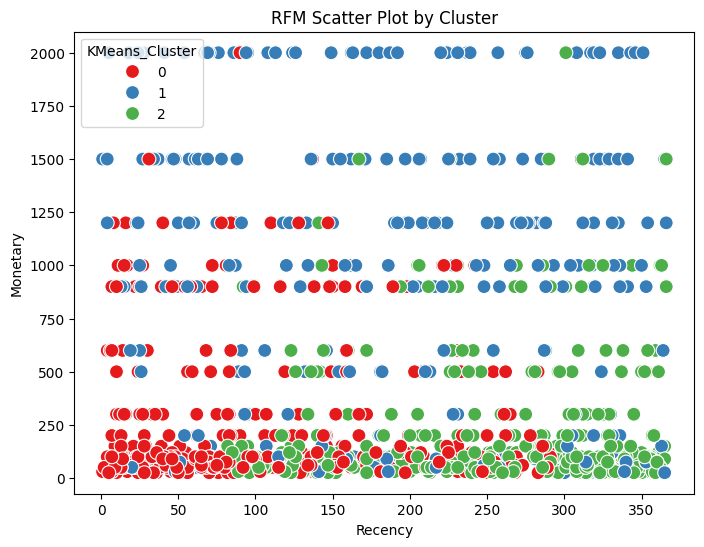

In [53]:
# RFM scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Recency', y='Monetary', hue='KMeans_Cluster', data=customer_df, palette='Set1', s=100)
plt.title('RFM Scatter Plot by Cluster')
plt.show()

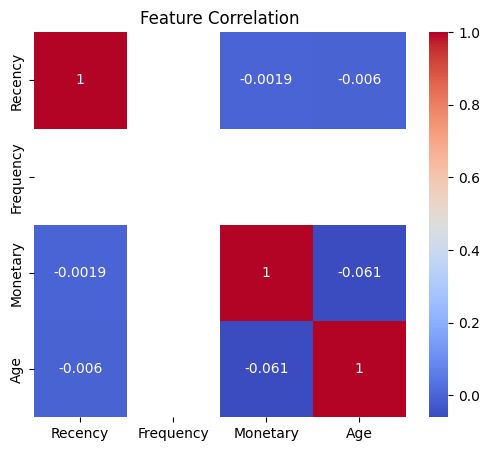

In [54]:

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(customer_df[['Recency','Frequency','Monetary','Age']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()